In [7]:
%load_ext autoreload
%autoreload 2
import sys
import matplotlib.pyplot as plt
import nibabel as nib
import utils, data_generator, train_util, models, loss_util
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.ndimage
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import Input
import os
from keras.models import Model
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import warnings
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)
    
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
fold = '1'
output_ch = 1
input_shape = (256, 256, 3)
# input_shape = (512, 512, 3)
target_shape = input_shape[:2]
img_ch = input_shape[-1]
# AUGMENTATIONS = Compose([
# #     HorizontalFlip(p=0.5),
#     OneOf([
#         RandomContrast(),
#         RandomGamma(),
#         RandomBrightness(),
#          ], p=0.3),
#     OneOf([
#         ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
#         GridDistortion(),
#         OpticalDistortion(distort_limit=2, shift_limit=0.5),
#         ], p=0.3),
#     RandomSizedCrop(min_max_height=(624, 1024), height=1024, width=1024,p=0.25),

#     ToFloat(max_value=1)
# ],p=1)

AUGMENTATIONS = Compose([
#     HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.3),
    OneOf([
#         ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
#         GridDistortion(),
#         OpticalDistortion(distort_limit=2, shift_limit=0.5),
        RandomSizedCrop(min_max_height=(624, 1024), height=1024, width=1024,p=0.25),
        ShiftScaleRotate(rotate_limit=10),
        ], p=0.5),
    ToFloat(max_value=1)
],p=1)
maxrotate=10
batch_size=16 
# batch_size=4
generator = data_generator.DataGenerator(batch_size=batch_size,
                                             img_ch=img_ch,
                                             data_path='/data/pneumo/fold/[!'+fold+']/',
                                             target_shape=target_shape,
                                             output_ch=output_ch,
                                             aug=AUGMENTATIONS)
train_gen, val_gen = generator.get_train_val_gens()
# train_gen = datagenerator.generate(train=True)
# val_gen = datagenerator.generate(train=False)
zero_weight=1
one_weight=1

(16, 256, 256, 3)
(16, 256, 256, 1)


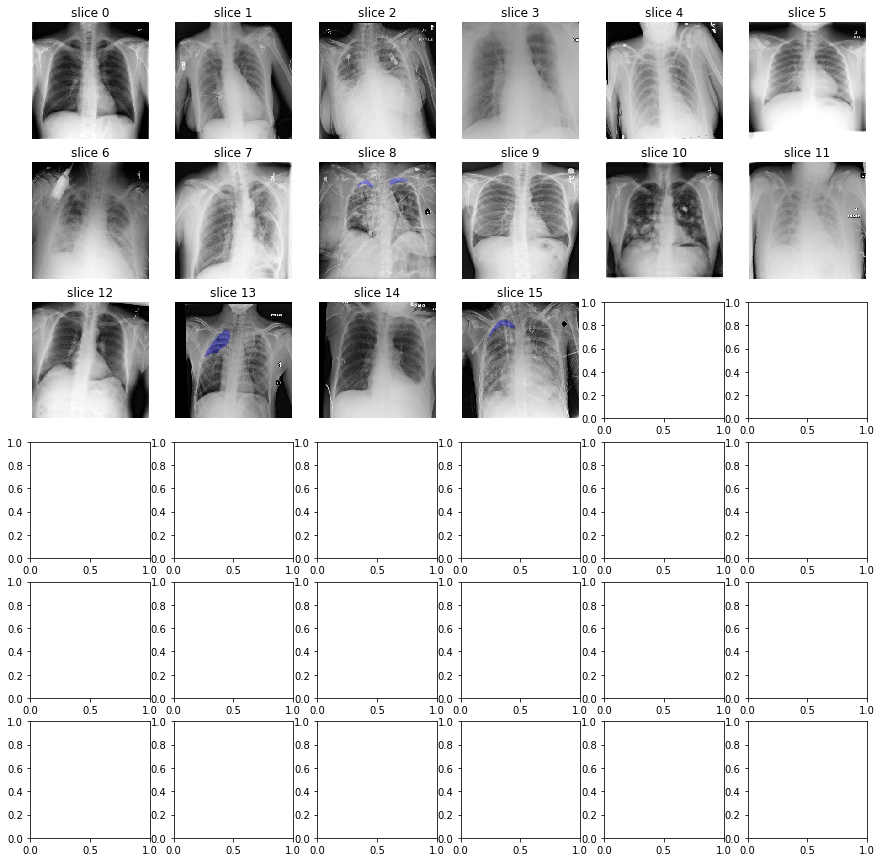

In [9]:
v, m = train_gen.__getitem__(0)
print(v.shape)
print(m.shape)
if img_ch == 3:
    v = v[:, :, :, 0]
# v = np.squeeze(v)
# m = np.argmax(m, axis=-1)
utils.vis_slices(v, m)


In [10]:

# model= models.unet(img_shape=input_shape, out_ch=output_ch, start_ch=16, depth=5) 
model = models.UEfficientNet(input_shape, dropout_rate=0.5)
load=False
#++++++++++++++++++++ LOAD MODEL++++++++++++++++++++++++++++++
if load:
    custom_objects = {
                    'weighted_binary_crossentropy':loss_util.create_weighted_binary_crossentropy(zero_weight, one_weight),
               'dice_coef':loss_util.create_dice_coef(),
               'dice_coef_flat':loss_util.dice_coef_flat,
               'bce_dice_loss':loss_util.bce_dice_loss,
               'dice_loss_flat':loss_util.dice_loss_flat,}
    model_path = '/data/pneumo_log/val_1//2019_0808_0447/best_weights.hdf5'
    loaded_model = load_model(model_path, custom_objects=custom_objects)
    if input_shape[0] != loaded_model.layers[0].input_shape[1]:
        model = models.UEfficientNet(input_shape, dropout_rate=0.5)
    #     new_input_l = Input((256, 256, 3))
        # try _layes instead of layers https://github.com/tensorflow/tensorflow/issues/22479
        loaded_model._layers.pop(0) # pop up doesn't support functional API? https://github.com/keras-team/keras/issues/8772
    #     new_out = loaded_model(new_input_l)
    #     model = Model(new_input_l, new_out)
        # set weights to avoid getting error in saving. https://github.com/keras-team/keras/issues/8772
        model.set_weights(loaded_model.get_weights())
    #     model = new_model

        # not try yet: https://datascience.stackexchange.com/questions/21734/keras-transfer-learning-changing-input-tensor-shape
    #     for new_layer, layer in zip(model.layers[1:], loaded_model.layers[1:]):
    #         print(layer)
    #         new_layer.set_weights(layer.get_weights())
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++
    else:
        model = loaded_model
    # loss = loss_util.create_weighted_binary_crossentropy(zero_weight, one_weight)
loss = loss_util.bce_dice_loss

optimizer = Adam(lr=0.001)
steps_per_epoch = len(train_gen.data_paths) // train_gen.batch_size
validation_steps = len(val_gen.data_paths) // val_gen.batch_size
log_dir = '/data/pneumo_log/' +'val_'+fold+'/'

metrics = [
           loss,
           loss_util.create_weighted_binary_crossentropy(zero_weight, one_weight),
           loss_util.create_dice_coef(),
           loss_util.dice_coef_flat,
           loss_util.bce_dice_loss,
           loss_util.dice_loss_flat,
           loss_util.my_dice_metric
          ]
epochs = 400
nb_snapshots=4


In [5]:
# model.summary()

In [ ]:
train_util.train(model,
             train_gen,
             val_gen,
             optimizer=optimizer,
             loss=loss,
             metrics=metrics,
             lr_mode='cosine',
             validation_steps=validation_steps,
             steps_per_epoch=steps_per_epoch,
             log_dir=log_dir,
             epochs=epochs,
             check_point_monitor='val_my_dice_metric',
             check_point_mode='max',
             nb_snapshots=nb_snapshots,
             init_lr=1e-3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 128, 128, 48) 1296        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_125 (BatchN (None, 128, 128, 48) 192         conv2d_150[0][0]                 
__________________________________________________________________________________________________
swish_97 (Swish)                (None, 128, 128, 48) 0           batch_normalization_125[0][0]    
__________________________________________________________________________________________________
depthwise_

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - 282s 587ms/step - loss: 0.3279 - bce_dice_loss: 0.3279 - weighted_binary_crossentropy: 0.0125 - dice_coef: 0.7382 - dice_coef_flat: nan - bce_dice_loss_1: 0.3279 - dice_loss_flat: 0.3154 - my_dice_metric: 0.8951 - val_loss: 0.5970 - val_bce_dice_loss: 0.5970 - val_weighted_binary_crossentropy: 0.0250 - val_dice_coef: 0.8002 - val_dice_coef_flat: 0.4283 - val_bce_dice_loss_1: 0.5970 - val_dice_loss_flat: 0.5720 - val_my_dice_metric: 0.8110
Finished epoch: 87
{'val_loss': 0.5970424332146375, 'val_bce_dice_loss': 0.597042516436217, 'val_weighted_binary_crossentropy': 0.02502410608906088, 'val_dice_coef': 0.8002472722305441, 'val_dice_coef_flat': 0.42827385296728815, 'val_bce_dice_loss_1': 0.597042516436217, 'val_dice_loss_flat': 0.5720183950550152, 'val_my_dice_metric': 0.8109892341503533, 'loss': 0.3279490810508529, 'bce_dice_loss': 0.32794912802055476, 'weighted_binary_crossentropy': 0.012506380908017433, 'dice_coef': 0.7382435852040847, 'dice_

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - 283s 590ms/step - loss: 0.4428 - bce_dice_loss: 0.4428 - weighted_binary_crossentropy: 0.0178 - dice_coef: 0.6421 - dice_coef_flat: nan - bce_dice_loss_1: 0.4428 - dice_loss_flat: 0.4251 - my_dice_metric: 0.8387 - val_loss: 0.6533 - val_bce_dice_loss: 0.6533 - val_weighted_binary_crossentropy: 0.0266 - val_dice_coef: 0.6949 - val_dice_coef_flat: 0.3735 - val_bce_dice_loss_1: 0.6533 - val_dice_loss_flat: 0.6267 - val_my_dice_metric: 0.7672
Finished epoch: 105
{'val_loss': 0.6532862942736104, 'val_bce_dice_loss': 0.6532859715088358, 'val_weighted_binary_crossentropy': 0.026563448897334484, 'val_dice_coef': 0.6949477960478585, 'val_dice_coef_flat': 0.3735375862287463, 'val_bce_dice_loss_1': 0.6532859715088358, 'val_dice_loss_flat': 0.6267224887631974, 'val_my_dice_metric': 0.7672137878844327, 'loss': 0.4428162849818667, 'bce_dice_loss': 0.44281630831149715, 'weighted_binary_crossentropy': 0.017755443759290775, 'dice_coef': 0.6420950890829166, 'di

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - 283s 589ms/step - loss: 0.3924 - bce_dice_loss: 0.3924 - weighted_binary_crossentropy: 0.0160 - dice_coef: 0.7055 - dice_coef_flat: nan - bce_dice_loss_1: 0.3924 - dice_loss_flat: 0.3764 - my_dice_metric: 0.8619 - val_loss: 0.6238 - val_bce_dice_loss: 0.6238 - val_weighted_binary_crossentropy: 0.0286 - val_dice_coef: 0.7009 - val_dice_coef_flat: 0.4055 - val_bce_dice_loss_1: 0.6238 - val_dice_loss_flat: 0.5952 - val_my_dice_metric: 0.7885
Finished epoch: 123
{'val_loss': 0.6238064467906952, 'val_bce_dice_loss': 0.6238064892449469, 'val_weighted_binary_crossentropy': 0.02863827686897426, 'val_dice_coef': 0.7008644589837992, 'val_dice_coef_flat': 0.40547225128788994, 'val_bce_dice_loss_1': 0.6238064892449469, 'val_dice_loss_flat': 0.5951682014285393, 'val_my_dice_metric': 0.7885488349793468, 'loss': 0.3924061483858774, 'bce_dice_loss': 0.39240617778462666, 'weighted_binary_crossentropy': 0.016025258321419263, 'dice_coef': 0.7054879643023014, 'di

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



479/480 [============================>.] - ETA: 0s - loss: 0.3032 - bce_dice_loss: 0.3032 - weighted_binary_crossentropy: 0.0122 - dice_coef: 0.8237 - dice_coef_flat: nan - bce_dice_loss_1: 0.3032 - dice_loss_flat: 0.2910 - my_dice_metric: 0.9044Finished epoch: 289
{'val_loss': 0.5976429533845974, 'val_bce_dice_loss': 0.5976429710972984, 'val_weighted_binary_crossentropy': 0.026232729268365732, 'val_dice_coef': 0.7896729505287027, 'val_dice_coef_flat': 0.4283560859039426, 'val_bce_dice_loss_1': 0.5976429710972984, 'val_dice_loss_flat': 0.5714102409920603, 'val_my_dice_metric': 0.8126127330226105, 'loss': 0.3014855393519004, 'bce_dice_loss': 0.30148553707792114, 'weighted_binary_crossentropy': 0.011950409960336325, 'dice_coef': 0.8241059064865113, 'dice_coef_flat': nan, 'bce_dice_loss_1': 0.30148553707792114, 'dice_loss_flat': 0.2895351306845744, 'my_dice_metric': 0.9039109725161019}
480/480 [==============================] - 282s 588ms/step - loss: 0.3029 - bce_dice_loss: 0.3029 - weig

In [20]:
model.get_config()

KeyError: 'input_3_ib-0'

## See training results

In [ ]:
# laod model
from keras.models import load_model
# model_path = '/data/kits_log/2019_0724_0242/best_weights.hdf5'
model_path = '/data/pneumo_log/val_1//2019_0805_0344/best_weights.hdf5'
custom_objects = {
                'weighted_binary_crossentropy':loss_util.create_weighted_binary_crossentropy(zero_weight, one_weight),
           'dice_coef':loss_util.create_dice_coef(),
           'dice_coef_flat':loss_util.dice_coef_flat,
           'bce_dice_loss':loss_util.bce_dice_loss,
           'dice_loss_flat':loss_util.dice_loss_flat,}
model = load_model(model_path, custom_objects=custom_objects)


In [101]:
images, masks = val_gen.__getitem__(0)
pred = model.predict(images)
index = 10

i = np.squeeze(images[index])
m = np.squeeze(masks[index])
p = np.squeeze(pred[index])
print(np.unique(p))

[9.1127363e-11 1.2514501e-10 1.7214875e-10 ... 3.5596595e-03 3.6568183e-03
 3.6711448e-03]


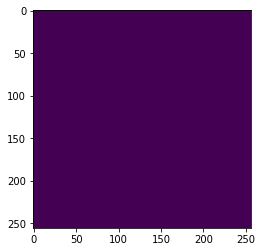

In [102]:
plt.imshow(m)

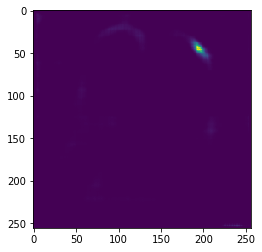

In [103]:
plt.imshow(p)

In [104]:
'/'.join(model_path.split('/')[:-2])

'/data/pneumo_log/val_1/'

In [105]:
m = np.expand_dims(m, axis=0)
p = np.expand_dims(p, axis=0)
m = np.expand_dims(m, axis=-1)
p = np.expand_dims(p, axis=-1)

In [106]:
import keras.backend as K
y_true = K.variable(m)
y_pred = K.variable(p)
# m = np.array(m, dtype=np.float32)
loss_flat = loss_util.dice_coef_flat(y_true, y_pred)
dice_coef = loss_util.create_dice_coef()
dice_value = dice_coef(y_true, y_pred)
loss = loss_util.bce_dice_loss(y_true, y_pred)

In [107]:

K.get_value(loss_flat)

nan

In [108]:
K.get_value(dice_value)

0.60813135

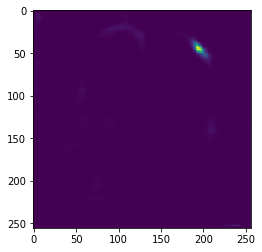

In [109]:
plt.imshow(np.reshape(K.get_value(loss), (256, 256)))

In [110]:
import eval_util

In [115]:
m = np.squeeze(m)
p = np.squeeze(p)
thresh=0.01
eval_util.evaluation(m, p, thresh)

1.0

In [112]:
np.unique(a)

array([1.])

In [99]:
# p = np.where(p>thresh, 1, 0)

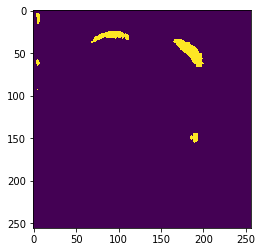

In [83]:
plt.imshow(p)

In [70]:
a = np.greater(p_binary, 0)

In [71]:
a.sum()

61169

In [ ]:
import cv2
cv2.resize(t, (256, 256, 3))